In [10]:
import argparse
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import Dict, Iterator

from torch.utils.data import DataLoader

from datasets.HMDB51Dataset import HMDB51Dataset
from models import model_creator
from utils import statistics

In [14]:
def create_datasets(
        frames_dir: str,
        annotations_dir: str,
        split: HMDB51Dataset.Split,
        clip_length: int,
        crop_size: int,
        temporal_stride: int
) -> Dict[str, HMDB51Dataset]:
    """
    Creates datasets for training, validation, and testing.

    Args:
        frames_dir (str): Directory containing the video frames (a separate directory per video).
        annotations_dir (str): Directory containing annotation files.
        split (HMDB51Dataset.Split): Dataset split (TEST_ON_SPLIT_1, TEST_ON_SPLIT_2, TEST_ON_SPLIT_3).
        clip_length (int): Number of frames of the clips.
        crop_size (int): Size of spatial crops (squares).
        temporal_stride (int): Receptive field of the model will be (clip_length * temporal_stride) / FPS.

    Returns:
        Dict[str, HMDB51Dataset]: A dictionary containing the datasets for training, validation, and testing.
    """
    datasets = {}
    for regime in HMDB51Dataset.Regime:
        datasets[regime.name.lower()] = HMDB51Dataset(
            frames_dir,
            annotations_dir,
            split,
            regime,
            clip_length,
            crop_size,
            temporal_stride,
            3
        )
    
    return datasets


def create_dataloaders(
        datasets: Dict[str, HMDB51Dataset],
        batch_size: int,
        batch_size_eval: int = 8,
        num_workers: int = 2,
        pin_memory: bool = True
    ) -> Dict[str, DataLoader]:
    """
    Creates data loaders for training, validation, and testing datasets.

    Args:
        datasets (Dict[str, HMDB51Dataset]): A dictionary containing datasets for training, validation, and testing.
        batch_size (int, optional): Batch size for the data loaders. Defaults to 8.
        num_workers (int, optional): Number of worker processes for data loading. Defaults to 2.
        pin_memory (bool, optional): Whether to pin memory in DataLoader for faster GPU transfer. Defaults to True.

    Returns:
        Dict[str, DataLoader]: A dictionary containing data loaders for training, validation, and testing datasets.
    """
    dataloaders = {}
    for key, dataset in datasets.items():
        dataloaders[key] = DataLoader(
            dataset,
            batch_size=(batch_size if key == 'training' else batch_size_eval),
            shuffle=(key == 'training'),  # Shuffle only for training dataset
            collate_fn=dataset.collate_fn,
            num_workers=num_workers,
            pin_memory=pin_memory
        )
            
    return dataloaders

In [15]:
parser = argparse.ArgumentParser(description='Train a video classification model on HMDB51 dataset.')

parser.frames_dir = "/ghome/group08/c6/week5/frames"
parser.annotations_dir = "../data/hmdb51/testTrainMulti_601030_splits"
parser.clip_length = 4
parser.crop_size = 182
parser.temporal_stride = 12
parser.model_name = "x3d_xs"
parser.load_pretrain = False
parser.num_workers = 2
parser.device = "cpu"
parser.batch_size = 16
parser.batch_size_eval = 16

args = parser

# Create datasets
datasets = create_datasets(
    frames_dir=args.frames_dir,
    annotations_dir=args.annotations_dir,
    split=HMDB51Dataset.Split.TEST_ON_SPLIT_1, # hardcoded
    clip_length=args.clip_length,
    crop_size=args.crop_size,
    temporal_stride=args.temporal_stride
)

# Create data loaders
loaders = create_dataloaders(
    datasets,
    args.batch_size,
    batch_size_eval=args.batch_size_eval,
    num_workers=args.num_workers
)

model = model_creator.create(args.model_name, args.load_pretrain, datasets["training"].get_num_classes())
model.load_state_dict(torch.load("../pretrained/best_model_task4.pth", map_location=args.device))

Using cache found in /ghome/group08/.cache/torch/hub/facebookresearch_pytorchvideo_main


<All keys matched successfully>

In [16]:
model.eval()
all_labels = []
all_predictions = []
for batch in tqdm(loaders['testing'], total=len(loaders['testing'])):
    # Gather batch and move to device
    clips, labels = batch['clips'].to(args.device), batch['labels'].to(args.device)
    # Forward pass
    with torch.no_grad():
        outputs = model(clips).argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(outputs.cpu().numpy())

100%|██████████| 95/95 [00:42<00:00,  2.23it/s]


In [9]:
# Calculate per-class accuracies for the baseline
from sklearn.metrics import accuracy_score

unique_labels = set(all_labels)
class_accuracies_baseline = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels) if x == label]
    class_preds = [all_predictions[i] for i in idxs]
    class_labels = [all_labels[i] for i in idxs]
    class_accuracies_baseline[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_baseline)

{0: 0.16666666666666666, 1: 0.6333333333333333, 2: 0.0, 3: 0.1, 4: 0.0, 5: 0.03333333333333333, 6: 0.034482758620689655, 7: 0.13793103448275862, 8: 0.1, 9: 0.7, 10: 0.0, 11: 0.5172413793103449, 12: 0.0, 13: 0.13333333333333333, 14: 0.03333333333333333, 15: 0.5, 16: 0.1, 17: 0.034482758620689655, 18: 0.0, 19: 0.20689655172413793, 20: 0.06896551724137931, 21: 0.0, 22: 0.0, 23: 0.3448275862068966, 24: 0.03333333333333333, 25: 0.0, 26: 0.06666666666666667, 27: 0.26666666666666666, 28: 0.3, 29: 0.13333333333333333, 30: 0.13793103448275862, 31: 0.1724137931034483, 32: 0.16666666666666666, 33: 0.8, 34: 0.4, 35: 0.06666666666666667, 36: 0.3333333333333333, 37: 0.16666666666666666, 38: 0.4666666666666667, 39: 0.36666666666666664, 40: 0.1, 41: 0.1, 42: 0.1724137931034483, 43: 0.1, 44: 0.03333333333333333, 45: 0.06666666666666667, 46: 0.1, 47: 0.06896551724137931, 48: 0.0, 49: 0.03333333333333333, 50: 0.03333333333333333}


In [17]:
# Calculate per-class accuracies for the new model
from sklearn.metrics import accuracy_score

unique_labels = set(all_labels)
class_accuracies_new_model = {}

for label in unique_labels:
    idxs = [i for i, x in enumerate(all_labels) if x == label]
    class_preds = [all_predictions[i] for i in idxs]
    class_labels = [all_labels[i] for i in idxs]
    class_accuracies_new_model[label] = accuracy_score(class_labels, class_preds)

print(class_accuracies_new_model)

{0: 0.36666666666666664, 1: 0.36666666666666664, 2: 0.0, 3: 0.03333333333333333, 4: 0.06666666666666667, 5: 0.1, 6: 0.0, 7: 0.3448275862068966, 8: 0.06666666666666667, 9: 0.6333333333333333, 10: 0.0, 11: 0.3793103448275862, 12: 0.0, 13: 0.23333333333333334, 14: 0.06666666666666667, 15: 0.6, 16: 0.3, 17: 0.20689655172413793, 18: 0.0, 19: 0.13793103448275862, 20: 0.06896551724137931, 21: 0.0, 22: 0.03333333333333333, 23: 0.27586206896551724, 24: 0.1, 25: 0.0, 26: 0.0, 27: 0.26666666666666666, 28: 0.26666666666666666, 29: 0.4, 30: 0.20689655172413793, 31: 0.3103448275862069, 32: 0.0, 33: 0.8666666666666667, 34: 0.03333333333333333, 35: 0.03333333333333333, 36: 0.13333333333333333, 37: 0.13333333333333333, 38: 0.4, 39: 0.06666666666666667, 40: 0.16666666666666666, 41: 0.13333333333333333, 42: 0.10344827586206896, 43: 0.3333333333333333, 44: 0.0, 45: 0.06666666666666667, 46: 0.43333333333333335, 47: 0.034482758620689655, 48: 0.0, 49: 0.0, 50: 0.16666666666666666}


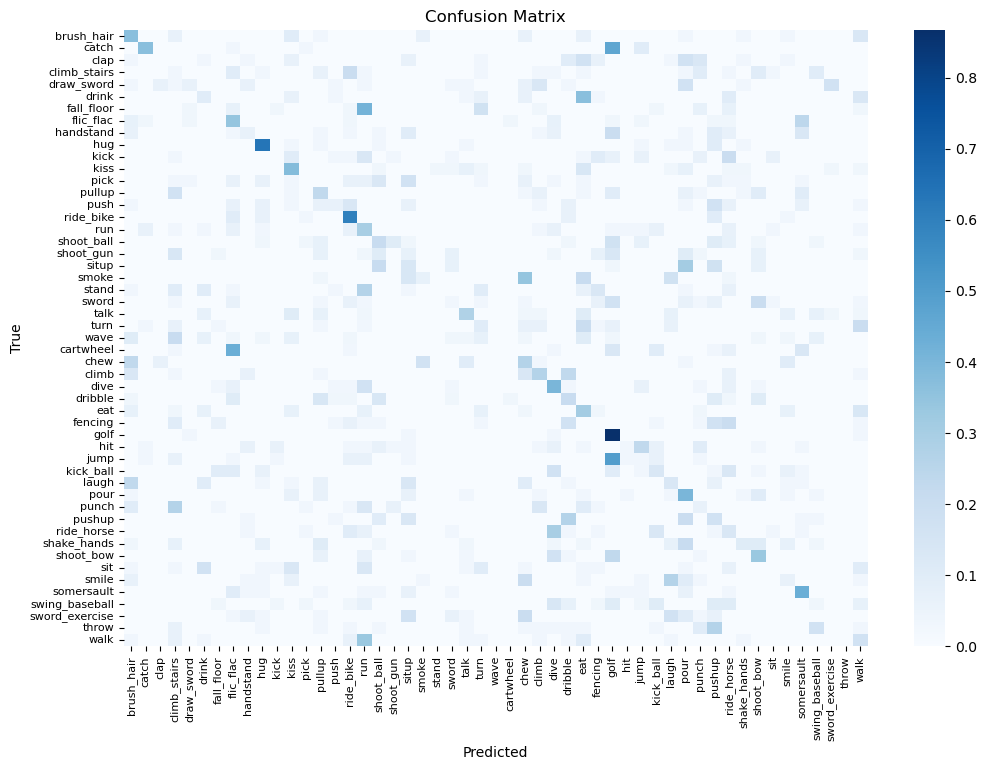

High misclassification from catch to golf: 0.4666666666666667
High misclassification from drink to eat: 0.36666666666666664
High misclassification from fall_floor to run: 0.41379310344827586
High misclassification from situp to pour: 0.3103448275862069
High misclassification from smoke to chew: 0.3448275862068966
High misclassification from cartwheel to flic_flac: 0.43333333333333335
High misclassification from jump to golf: 0.5
High misclassification from walk to run: 0.3333333333333333


In [18]:
# PLOT CONFUSION MATRIX
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = datasets["training"].CLASS_NAMES

cm = confusion_matrix(all_labels, all_predictions)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title('Confusion Matrix')
plt.show()

def highlight_errors(confusion_matrix, class_names):
    np.fill_diagonal(confusion_matrix, 0)  # Ignore diagonal elements (true positives)
    high_error_indices = np.where(confusion_matrix > np.percentile(confusion_matrix, 95))
    for row, col in zip(*high_error_indices):
        if confusion_matrix[row, col] > 0.3:
            print(f"High misclassification from {class_names[row]} to {class_names[col]}: {confusion_matrix[row, col]}")

highlight_errors(cm, class_names)

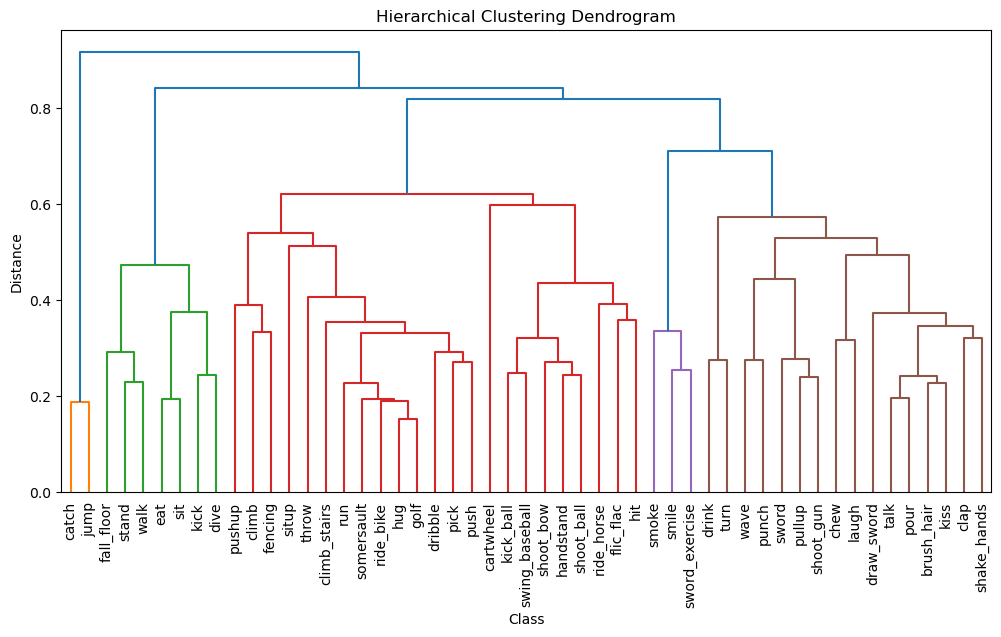

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

def plot_dendrogram(confusion_matrix, class_names):
    # Use linkage to perform hierarchical clustering
    Z = linkage(confusion_matrix, 'ward')
    plt.figure(figsize=(12, 6))
    dendrogram(Z, labels=class_names, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Class')
    plt.ylabel('Distance')
    plt.xticks(fontsize=10)
    plt.show()

plot_dendrogram(cm, class_names)

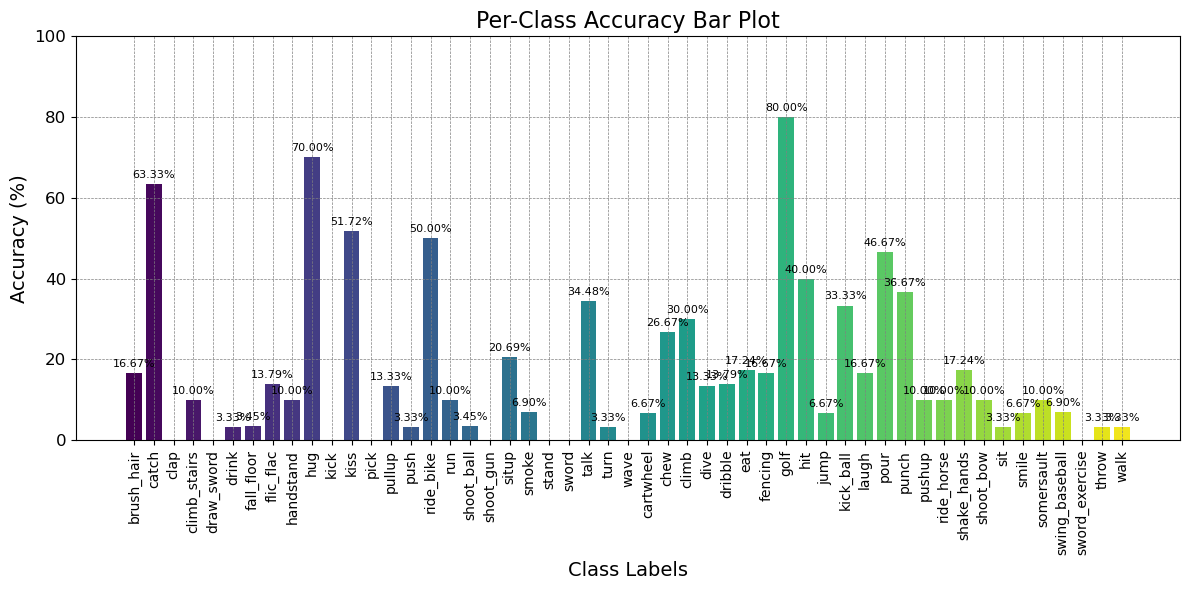

In [20]:
import matplotlib.pyplot as plt

class_names = datasets["training"].CLASS_NAMES

labels = list(class_accuracies_baseline.keys())
accuracies = [class_accuracies_baseline[lbl] * 100 for lbl in labels]  # Convert fractions to percentages

# Use a visually appealing color scheme, such as a sequential palette
colors = plt.cm.viridis([i/len(labels) for i in range(len(labels))])

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, accuracies, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Per-Class Accuracy Bar Plot', fontsize=16)
plt.xticks(rotation=90, fontsize=10)  # Rotate class labels for better visibility
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # Set y-axis to show percentage
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')  # Add gridlines
plt.tight_layout()  # Adjust layout to make room for label rotation

# Optional: Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval > 0:
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=0)

plt.show()


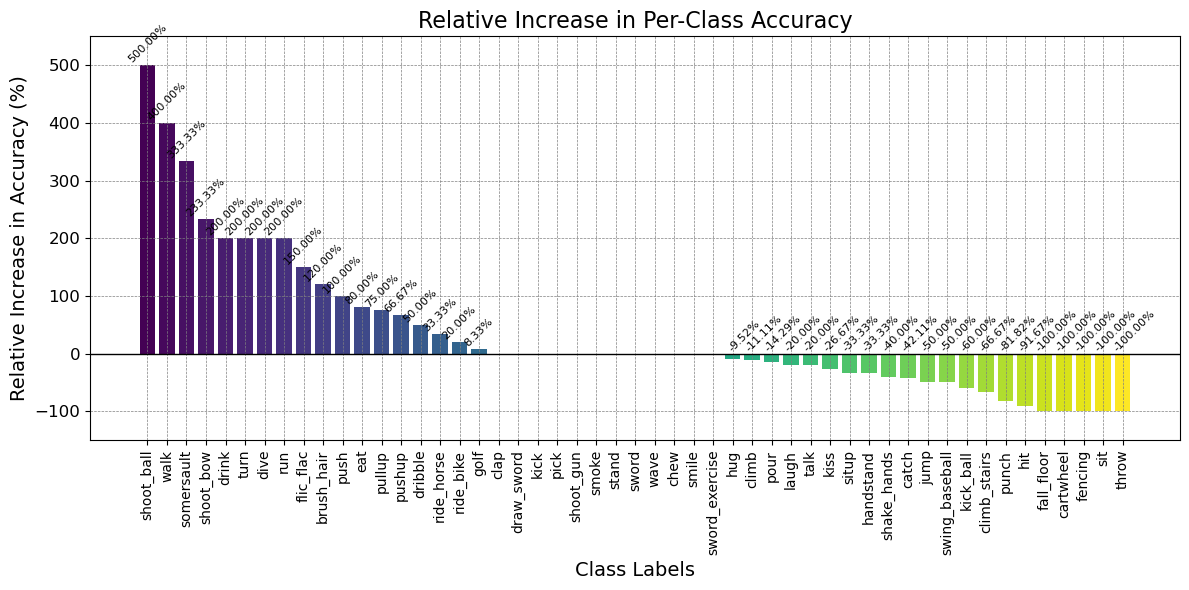

In [52]:
# Example data
class_accuracies_model1 = class_accuracies_baseline
class_accuracies_model2 = class_accuracies_new_model
#class_accuracies_model2 = {k: v + 0.1 for k, v in class_accuracies_baseline.items()} # CHANGE THIS TO YOUR OWN DATA (PREVIOUS LINE)

# Calculating relative increase in accuracy
relative_increase = {}
for lbl in class_accuracies_baseline.keys():
    initial = class_accuracies_baseline[lbl]
    new = class_accuracies_model2[lbl]
    if initial != 0:
        increase = (new - initial) / initial * 100
    else:
        increase = 0
    relative_increase[lbl] = increase

# Assuming class names as labels
class_names = datasets["training"].CLASS_NAMES

# Sort the increase and labels accordingly
sorted_items = sorted(relative_increase.items(), key=lambda x: x[1], reverse=True)
sorted_labels, sorted_increases = zip(*sorted_items)
sorted_names = [class_names[lbl] for lbl in sorted_labels]

# Use a visually appealing color scheme
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_labels)))

# Create a professional looking bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_names, sorted_increases, color=colors)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Relative Increase in Accuracy (%)', fontsize=14)
plt.title('Relative Increase in Per-Class Accuracy', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(min(sorted_increases) - 50, max(sorted_increases) + 50)
plt.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
plt.tight_layout()
plt.axhline(y=0.0, color='black', linewidth=1, linestyle='-')

# Adding value labels on bars
for bar in bars:
    yval = bar.get_height()
    if yval != 0:
        horizontal_offset = bar.get_width()/2 if yval > 0 else 1.25*bar.get_width()
        vertical_offset = yval + 1 if yval > 0 else 0
        plt.text(bar.get_x() + horizontal_offset, vertical_offset, f'{yval:.2f}%', ha='center', va='bottom', fontsize=8, rotation=45)

plt.show()
